![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [3]:
import warnings
warnings.filterwarnings('ignore')
%pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [153]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier, export_graphviz
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

#1.1 Analisis Season

Los datos están completos y se dividen en cuatro temporadas distintas. La media y la desviación estándar de los datos tienen valores similares, ambos en el rango de 160-240 para un rango de valores de 1-800. Esto sugiere una dispersión significativa de los datos tanto por encima como por debajo del valor promedio.

Se observan valores atípicos que están muy alejados del grueso de los datos, lo que se evidencia en los cuartiles. El 75% de los datos se encuentran en un rango de 160-350, mientras que los valores máximos se extienden hasta 800. Esto sugiere la presencia de días "calientes" y "fríos", lo que podría ser objeto de una hipótesis para su desarrollo adicional.

Completitud

Resultados:
       Columna  Espacios en Blanco  NaN  % Faltantes
0       season                   0    0          0.0
1      holiday                   0    0          0.0
2   workingday                   0    0          0.0
3      weather                   0    0          0.0
4         temp                   0    0          0.0
5        atemp                   0    0          0.0
6     humidity                   0    0          0.0
7    windspeed                   0    0          0.0
8       casual                   0    0          0.0
9   registered                   0    0          0.0
10       total                   0    0          0.0
11        hour                   0    0          0.0


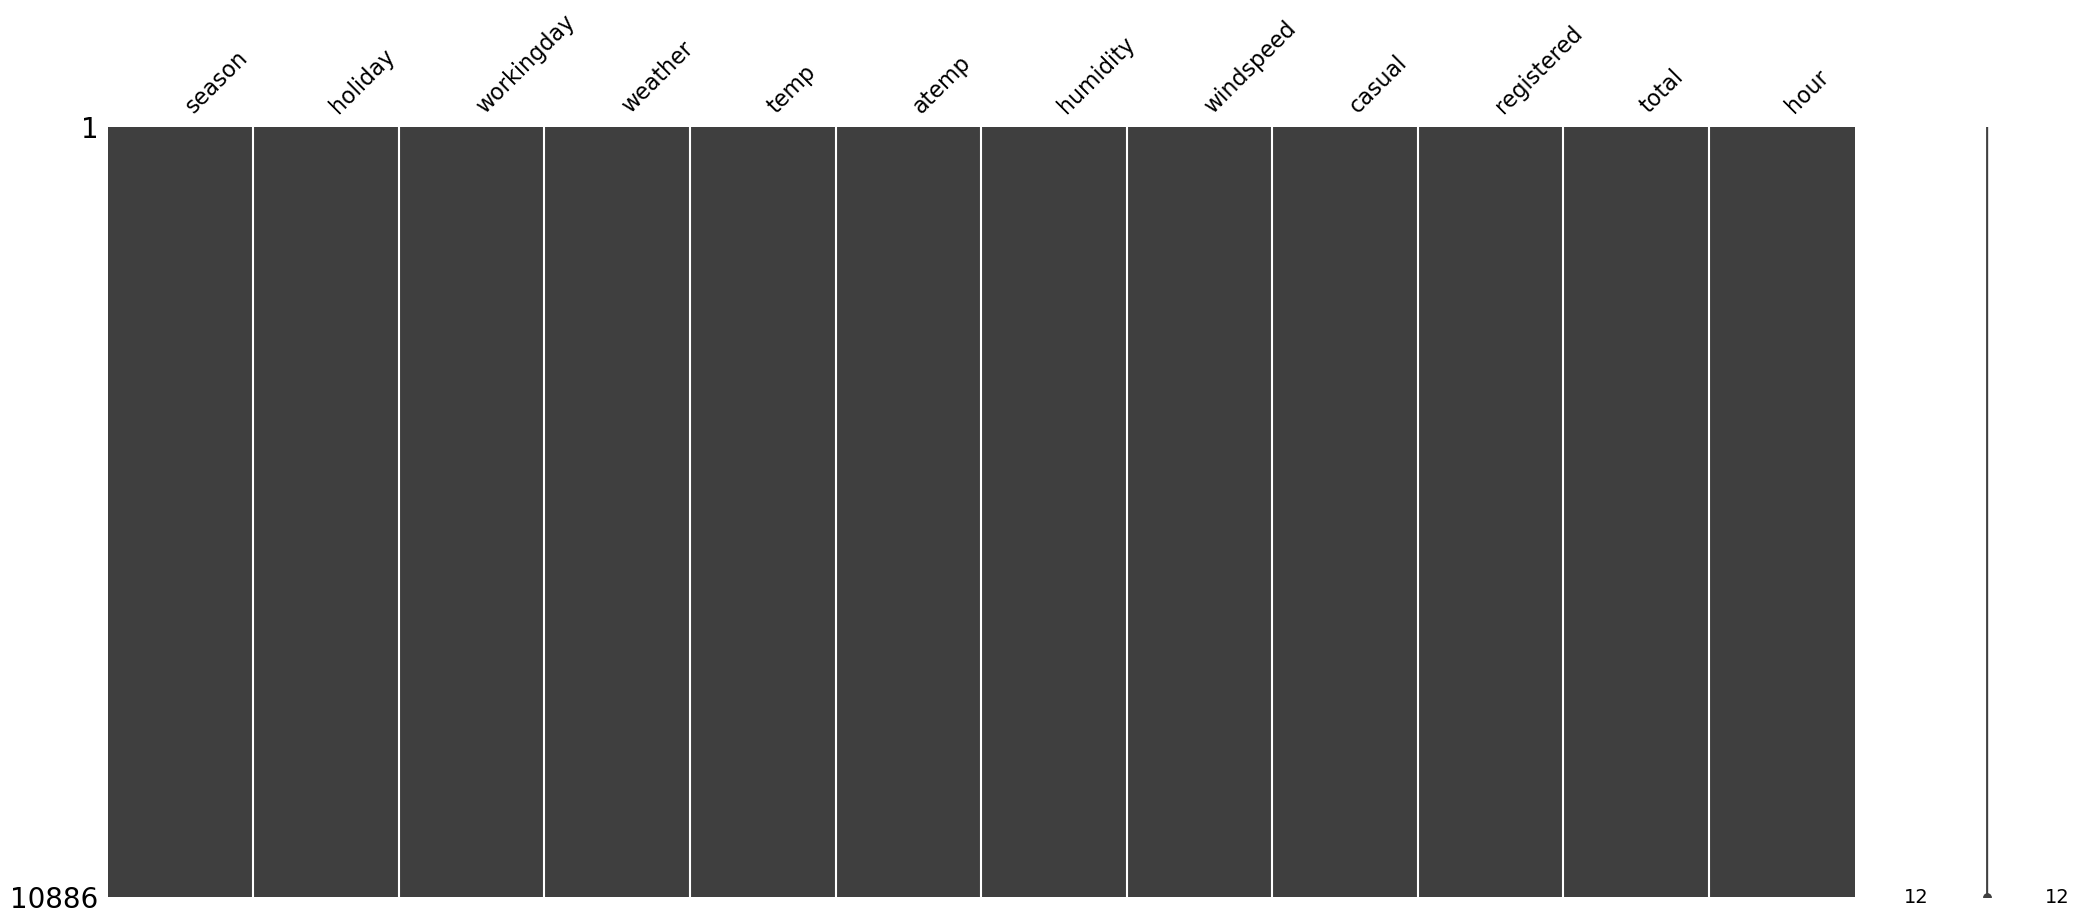

In [6]:
# Completitud de los datos
def analisis_datos(df):
    columnas = []
    espacios_blanco = []
    nan_counts = []
    porcentaje_faltantes = []

    for columna in df.columns:
        espacios_blanco.append(sum(df[columna].apply(lambda x: isinstance(x, str) and x.isspace())))
        nan_counts.append(df[columna].isna().sum())
        porcentaje_faltantes.append((df[columna].isna().sum() + espacios_blanco[-1]) / len(df) * 100)  # Calcula el porcentaje de datos faltantes
        columnas.append(columna)

    resultados_df = pd.DataFrame({
        'Columna': columnas,
        'Espacios en Blanco': espacios_blanco,
        'NaN': nan_counts,
        '% Faltantes': porcentaje_faltantes  # Agrega la columna de porcentaje de datos faltantes
    })

    print("Resultados:")
    print(resultados_df)

    msno.matrix(df)

analisis_datos(bikes)

In [29]:
# Celda 1.1
#descripcion General
bikes.groupby('season').total.describe()




,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


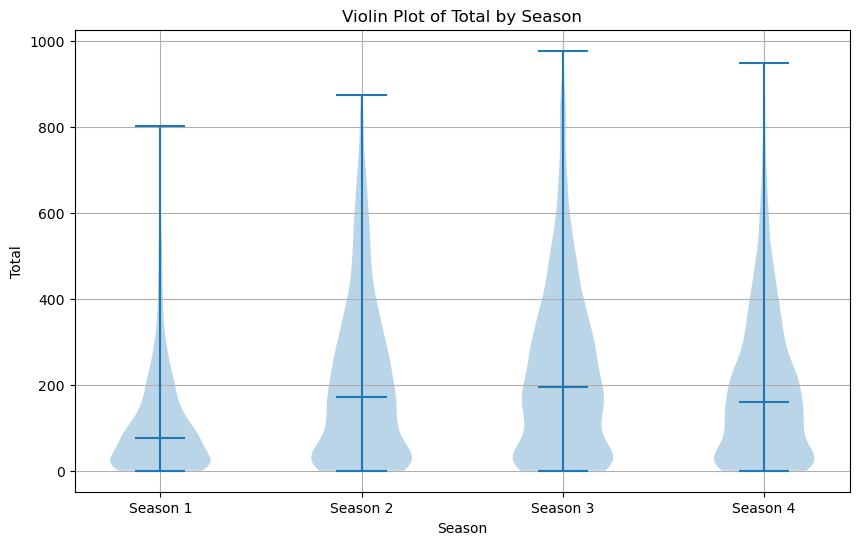

In [30]:
plt.figure(figsize=(10, 6))
plt.violinplot(dataset=[
  bikes[bikes['season'] == 1]['total'],
  bikes[bikes['season'] == 2]['total'],
  bikes[bikes['season'] == 3]['total'],
  bikes[bikes['season'] == 4]['total']],
  showmeans=False,
  showmedians=True)
plt.xticks([1, 2, 3, 4], ['Season 1', 'Season 2', 'Season 3', 'Season 4'])
plt.xlabel('Season')
plt.ylabel('Total')
plt.title('Violin Plot of Total by Season')
plt.grid(True)
plt.show()

#1.2 Analisis hour

Se observa un patrón específico en las horas del día, especialmente durante las horas pico de movilidad, donde se registra una media alta. Sin embargo, se destaca un comportamiento particular en el rango horario de 21:00 a 06:00 del día siguiente, donde la desviación estándar es notablemente baja en comparación con el resto de las horas.

In [8]:
# Celda 1.2
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

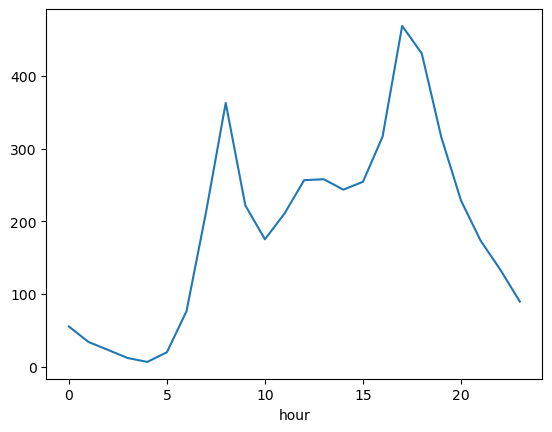

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

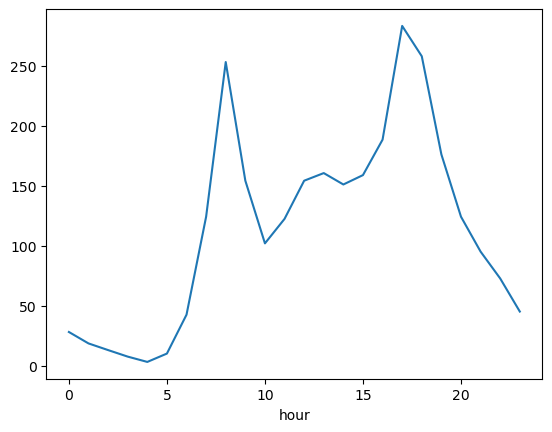

In [35]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

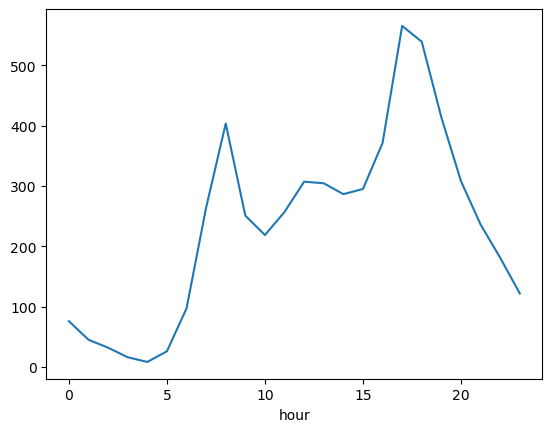

In [36]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot()

A pesar de que las gráficas muestran un comportamiento similar tanto en invierno como en verano, se observa un cambio notable en el volumen de bicicletas prestadas, casi duplicándose durante el verano. Este aumento en el verano es coherente con el clima más favorable que las personas prefieren para realizar actividades al aire libre.

Es importante señalar que, aunque la proporción de personas que utilizan las bicicletas en las horas pico de la mañana siempre es menor que en las horas pico de la tarde en ambos casos, en invierno hay una menor variación entre estas dos. Esto sugiere que durante el invierno, las personas tienden a utilizar las bicicletas tanto para ir como para regresar.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [140]:
# Celda 3
X = bikes[['hour','season']]
X_dummy=pd.get_dummies(X,columns=['season'],drop_first=True)
y=bikes['total']
XTrain,XTest,yTrain,yTest=train_test_split(X_dummy,y,test_size=0.2,random_state=42)

lr=LinearRegression()
lr.fit(XTrain,yTrain)
prediction=lr.predict(XTest)

RL_MSE=mean_squared_error(yTest,prediction)
RL_r2=r2_score(yTest,prediction)

print(f'MSE:{RL_MSE}',f'R^2:{RL_r2}')

MSE:25409.920498970594 R^2:0.2301642114593645


El Error Cuadrático Medio (MSE) es de 25 mil, lo cual es significativamente alto considerando que los valores totales oscilan entre 1 y 800 aproximadamente. Además, el coeficiente de determinación $R^2$ es de 0.23, lo que indica un rendimiento pobre del modelo de regresión lineal. Este resultado sugiere que el problema no se ajusta completamente a un modelo de regresión lineal.

Sin embargo, este bajo rendimiento puede ser explicado, al menos en parte, por la alta variabilidad en los datos. Aunque la regresión lineal podría ser adecuada para predecir el número de bicicletas prestadas en horarios con menor desviación estándar, donde la relación entre las variables predictoras y la variable objetivo puede ser más lineal, como una hipótesis a explorar en análisis posteriores.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [146]:
# Celda 4

#Función de varianza
def var(y):
  if y.shape[0] == 0:
    return 0
  else:
    return np.var(y)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def var_impurity(X_col, y, split):
  filter_l = X_col < split
  y_l = y.loc[filter_l]
  y_r = y.loc[~filter_l]
  n_l = y_l.shape[0]
  n_r = y_r.shape[0]
  var_y = var(y)
  var_l = var(y_l)
  var_r = var(y_r)
  var_impurity_ = var_y - (n_l / (n_l + n_r) * var_l + n_r / (n_l + n_r) * var_r)
  return var_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
  features = range(X.shape[1])
  best_split = [0, 0, 0]  # j, split, gain  
  # Para todas las varibles 
  for j in features:
    splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
    splits = np.unique(splits)[1:]
    # Para cada partición
    for split in splits:
      gain = var_impurity(X.iloc[:, j], y, split)   
      if gain > best_split[2]:
        best_split = [j, split, gain]
  return best_split

In [147]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean())
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
XTrain_m,XTest_m,yTrain_m,yTest_m=train_test_split(X,y,test_size=0.2,random_state=42)
tree=tree_grow(XTrain_m, yTrain_m, level=0, min_gain=0.001, max_depth=6, num_pct=10)

In [148]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

tree_predict(XTest, tree)

array([127.,  44., 266., ..., 161.,  20., 161.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

(13454.101382166964, 11)


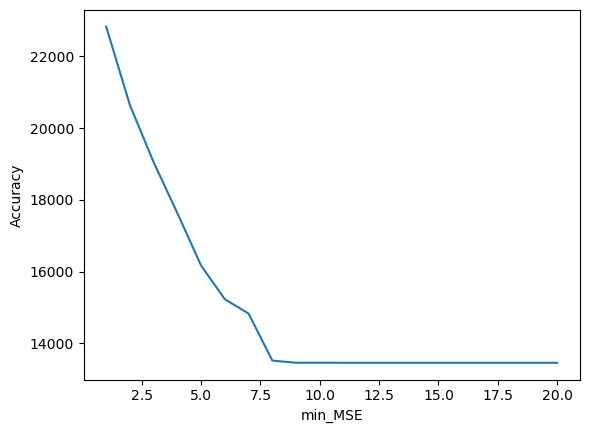

In [125]:
# Celda 5
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

for i in max_depth_range:
    tree = DecisionTreeRegressor(max_depth=i, random_state=42)
    tree.fit(XTrain, yTrain)
    prediction = tree.predict(XTest)
    accuracy_scores.append(mean_squared_error(yTest, prediction))
best_depth=sorted(zip(accuracy_scores, max_depth_range))[::1][0]
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('min_MSE')
plt.ylabel('Accuracy')
print(best_depth)

In [136]:
# Parámetros a evaluar
param_grid = {
    'max_depth': range(1,20),
    'min_samples_split': range(2,25),
    'min_samples_leaf': range(1,35),
    'max_features': ['sqrt', 'log2', None]
}

# Definir el modelo y la métrica de evaluación
modelo = DecisionTreeRegressor()
metric = 'neg_mean_squared_error'

# Búsqueda en grilla para optimizar hiperparámetros
grid_search = GridSearchCV(modelo, param_grid, scoring=metric, cv=5)

# Entrenar el modelo con la búsqueda en grilla
grid_search.fit(XTrain, yTrain)

# Imprimir los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
score = grid_search.best_score_

print("Mejor puntaje:", score)

Mejores parámetros: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13}
Mejor puntaje: -12951.0173178055


In [142]:
model=DecisionTreeRegressor(max_depth=11,max_features='sqrt',min_samples_leaf=1,min_samples_split=13,random_state=42)
model.fit(XTrain,yTrain)
prediction=model.predict(XTest)

DT_MSE=mean_squared_error(yTest,prediction)
DT_r2=r2_score(yTest,prediction)

print(f'MSE:{DT_MSE}',f'R^2:{DT_r2}')

MSE:13454.101382166964 R^2:0.5923856295785829


<h2>Comparacion de modelos</h2>

A continuacion concluimos con la mejora del modelo de arbol de decision que tanto su MSE como su R2 son modestamente mejores al modelo de regresion lineal.

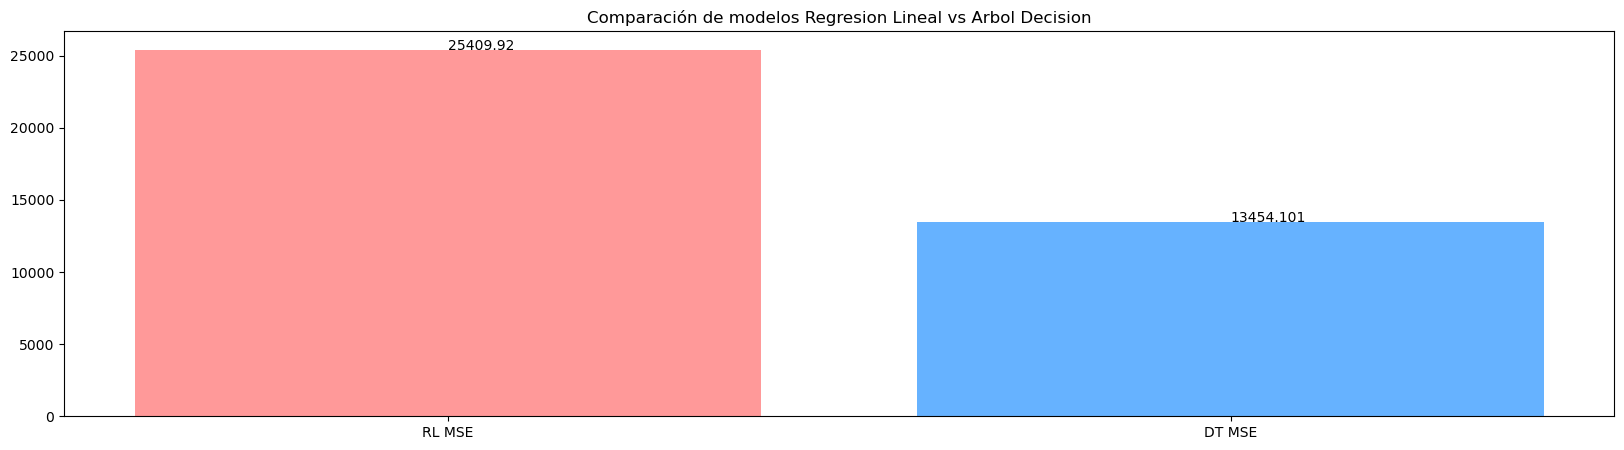

In [144]:
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))  # Cambio aquí a 1, 1
ax.set_title("Comparación de modelos Regresion Lineal vs Arbol Decision")
ejeX = ['RL MSE','DT MSE']
ejeY = [round(RL_MSE,3),round(DT_MSE,3)]
ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])

addlabels(ejeX, ejeY, ax)
plt.show()

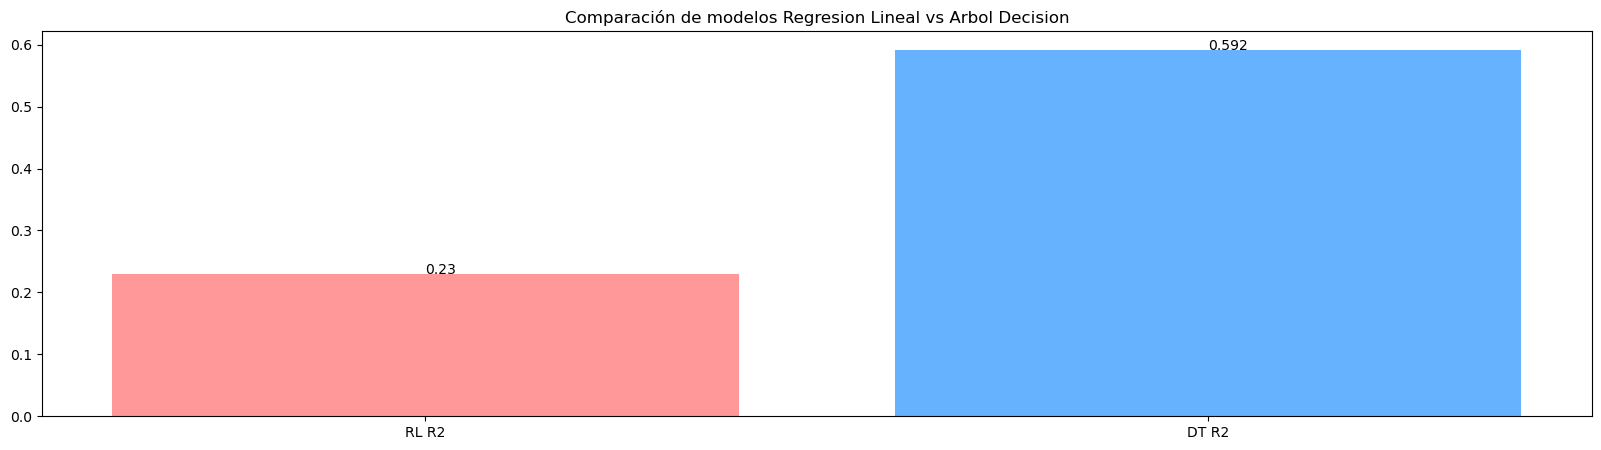

In [145]:
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))  # Cambio aquí a 1, 1
ax.set_title("Comparación de modelos Regresion Lineal vs Arbol Decision")
ejeX = ['RL R2','DT R2']
ejeY = [round(RL_r2,3),round(DT_r2,3)]
ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])

addlabels(ejeX, ejeY, ax)
plt.show()

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [159]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [160]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [161]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [165]:
# Celda 6
# Regresion logistica
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
LR_accuracy = accuracy_score(y_test, y_pred)
LR_f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {LR_accuracy}', f'F1: {LR_f1}')


Accuracy: 0.614 F1: 0.6111484217595702


In [ ]:
param_grid = {
    'max_depth': range(1,20),
    'min_samples_split': range(2,20),
    'min_samples_leaf': range(1,10),
    'max_features': ['sqrt', 'log2', None]
}

# Definir el modelo y la métrica de evaluación
DT_class = DecisionTreeClassifier()
metric = 'accuracy'

# Búsqueda en grilla para optimizar hiperparámetros
grid_search = GridSearchCV(modelo, param_grid, scoring=metric, cv=10)

# Entrenar el modelo con la búsqueda en grilla
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
score = grid_search.best_score_

print("Mejor puntaje:", score)

In [171]:
DT_class=DecisionTreeClassifier(max_depth=1,max_features=None,min_samples_leaf=1,min_samples_split=2,random_state=42)
DT_class.fit(X_train,y_train)
prediction=DT_class.predict(X_test)
y_pred = logreg.predict(X_test)
DT_accuracy = accuracy_score(y_test, y_pred)
DT_f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {DT_accuracy}', f'F1: {DT_f1}')


Accuracy: 0.614 F1: 0.6111484217595702


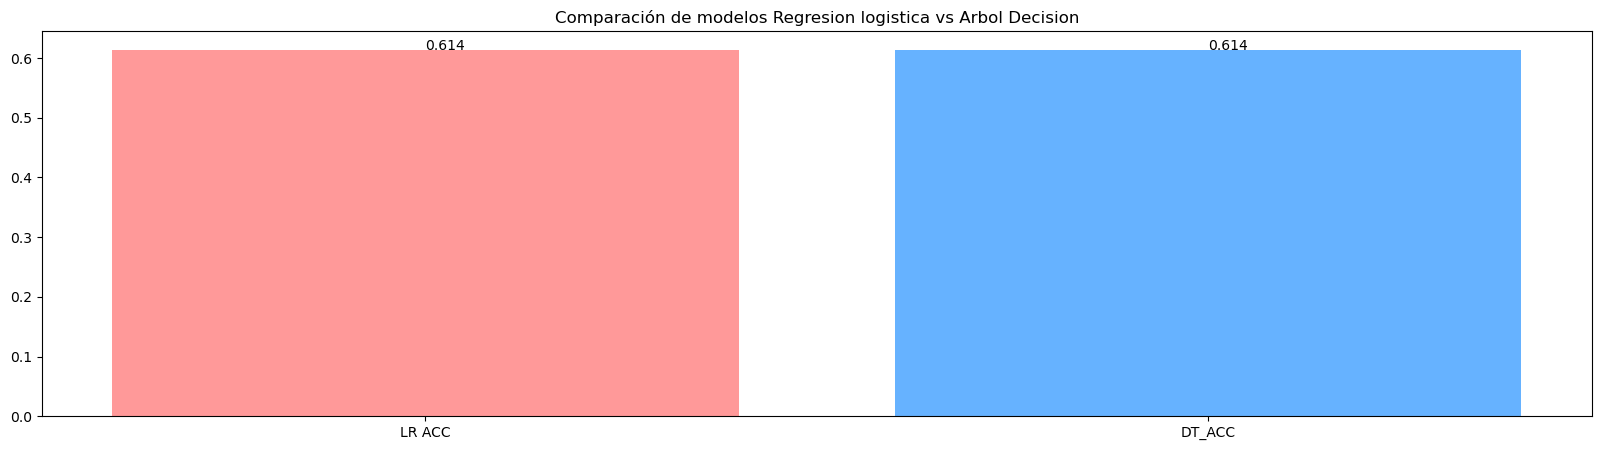

In [172]:
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))  # Cambio aquí a 1, 1
ax.set_title("Comparación de modelos Regresion logistica vs Arbol Decision")
ejeX = ['LR ACC','DT_ACC']
ejeY = [round(LR_accuracy,3),round(DT_accuracy,3)]
ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])

addlabels(ejeX, ejeY, ax)
plt.show()

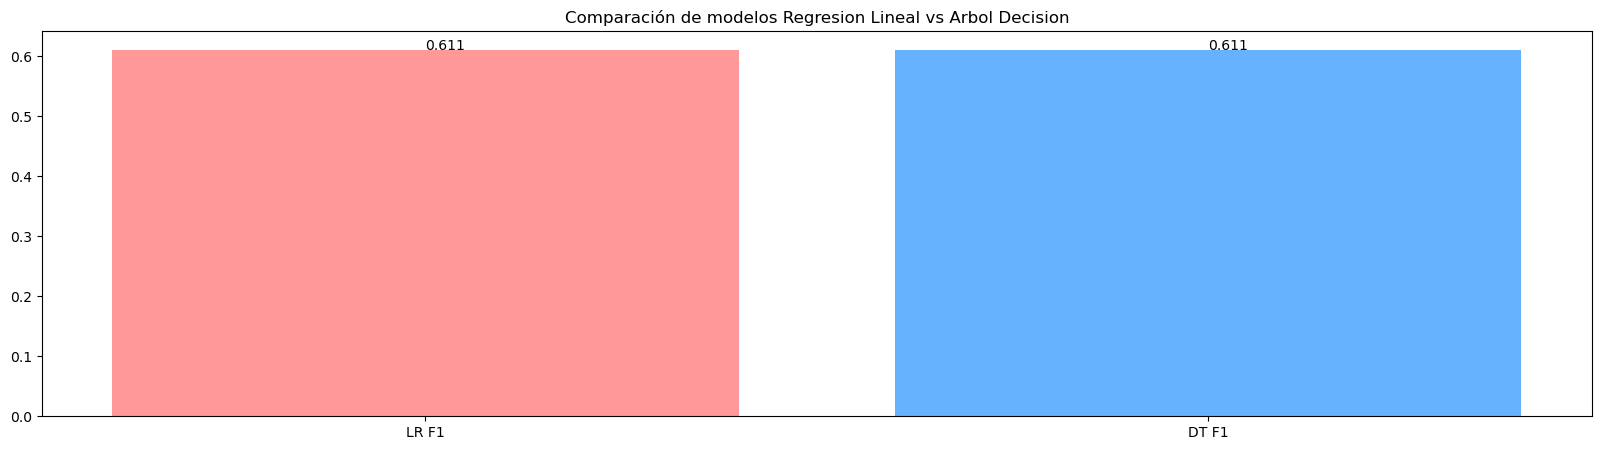

In [173]:
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))  # Cambio aquí a 1, 1
ax.set_title("Comparación de modelos Regresion Lineal vs Arbol Decision")
ejeX = ['LR F1','DT F1']
ejeY = [round(LR_f1,3),round(DT_f1,3)]
ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])

addlabels(ejeX, ejeY, ax)
plt.show()

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [177]:
# Celda 7
n_estimators = 300
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

# Entrenamiento de 100 modelos con las 100 muestras boostrap

from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

#Creacion de modelos
trees = {}
for i in range(n_estimators):
    for i in range(0,99):
        trees[i] = DecisionTreeClassifier(max_depth=6, random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    for i in range(100,199):
        trees[i] = DecisionTreeClassifier(min_samples_leaf=2, random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    for i in range(200,299):
        trees[i]=LogisticRegression(random_state=seeds[i])
        trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print(f'Accuracy: {accuracy_score(y_pred, y_test)}', f'F1: {f1_score(y_pred, y_test)}')
print(trees)

In [ ]:
VM_acc=accuracy_score(y_pred, y_test)
VM_f1=f1_score(y_pred, y_test)

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
alpha = (1 - errors) / (1 - errors).sum()
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
y_pred_VP = (weighted_sum_1 >= 0.5).astype(np.int)
VP_Acc=accuracy_score(y_pred_VP, y_test)
VP_F1=f1_score(y_pred_VP, y_test)
print(f'Accuracy: {VP_Acc}', f'F1: {VP_F1}')

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))  # Cambio aquí a 1, 1
ax.set_title("Comparación de modelos ensamble Voto Mayoritario vs Voto Ponderado")
ejeX = ['VM F1','VP F1']
ejeY = [round(VM_f1,3),round(VP_F1,3)]
ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])

addlabels(ejeX, ejeY, ax)
plt.show()

In [ ]:
# Celda 9
colors = ['#FF9999', '#66B2FF']
fig, ax = plt.subplots(1, 1, figsize=(20, 5))  # Cambio aquí a 1, 1
ax.set_title("Comparación de modelos ensamble Voto Mayoritario vs Voto Ponderado")
ejeX = ['VM Acc','VP Acc']
ejeY = [round(VM_acc,3),round(VP_Acc,3)]
ax.bar(ejeX, ejeY, color=colors)

def addlabels(x, y, plotP):
    for i in range(len(x)):
        plotP.text(i, y[i], y[i])

addlabels(ejeX, ejeY, ax)
plt.show()